In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import os

In [4]:
def preparar_serie(df, target_col="total", n_lags=30):
    df = df.sort_values("fecha").copy()
    df.set_index("fecha", inplace=True)
    df = df.drop(columns=["sentido_1", "sentido_2"], errors="ignore")

    # Crear lags
    for i in range(1, n_lags + 1):
        df[f"lag_{i}"] = df[target_col].shift(i)

    # Features de calendario
    df["dayofweek"] = df.index.dayofweek
    df["day"] = df.index.day
    df["month"] = df.index.month

    # Quitar filas con NaNs por los lags
    df = df.dropna()

    if df.empty or len(df) < 50:
        raise ValueError("Muy pocos datos útiles después de generar lags")

    # -------------------------------
    # Mantener solo columnas numéricas (solución al error de XGBoost)
    # -------------------------------
    df_numeric = df.select_dtypes(include=["number"]).copy()

    # Target y features
    y = df_numeric[target_col]
    X = df_numeric.drop(columns=[target_col])

    return X, y, df

In [5]:
def predecir_futuro(model, df, dias_futuros=30):
    df = df.copy()
    last_date = df.index[-1]

    for _ in range(dias_futuros):
        next_date = last_date + pd.Timedelta(days=1)

        new_row = {}

        # Lags
        for lag in range(1, 31):
            new_row[f"lag_{lag}"] = df["total"].iloc[-lag]

        # Calendario
        new_row["dayofweek"] = next_date.dayofweek
        new_row["day"] = next_date.day
        new_row["month"] = next_date.month

        X_new = pd.DataFrame([new_row])

        pred = model.predict(X_new)[0]

        df.loc[next_date, "total"] = pred
        last_date = next_date

    return df

In [6]:
def entrenar_modelo_peaje(df_peaje, dias_prediccion=30):
    X, y, df_proc = preparar_serie(df_peaje)

    # Train-test split diario
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # Modelo XGBoost
    model = xgb.XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror"
    )

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)

    print(f"💡 MAE del peaje: {mae:.2f}")

    df_future = predecir_futuro(model, df_proc, dias_futuros=dias_prediccion)

    return model, df_proc, df_future, X_test.index, y_test, preds


=========== Procesando peaje PTO. TRIUNFO ===========
💡 MAE del peaje: 798.97


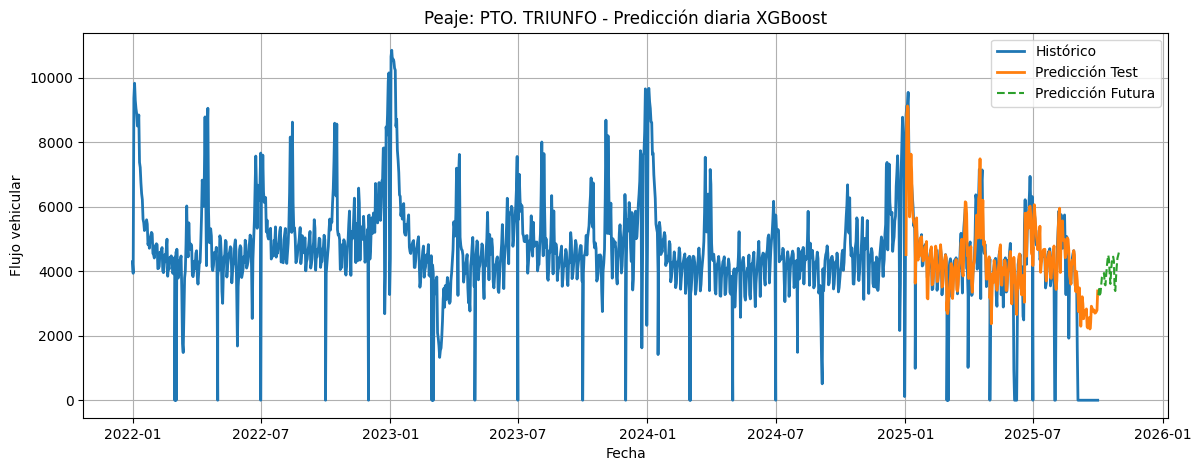

📁 CSV guardado en: ./resultados/PTO._TRIUNFO/predicciones_PTO._TRIUNFO.csv

=========== Procesando peaje SACHICA ===========
💡 MAE del peaje: 805.54


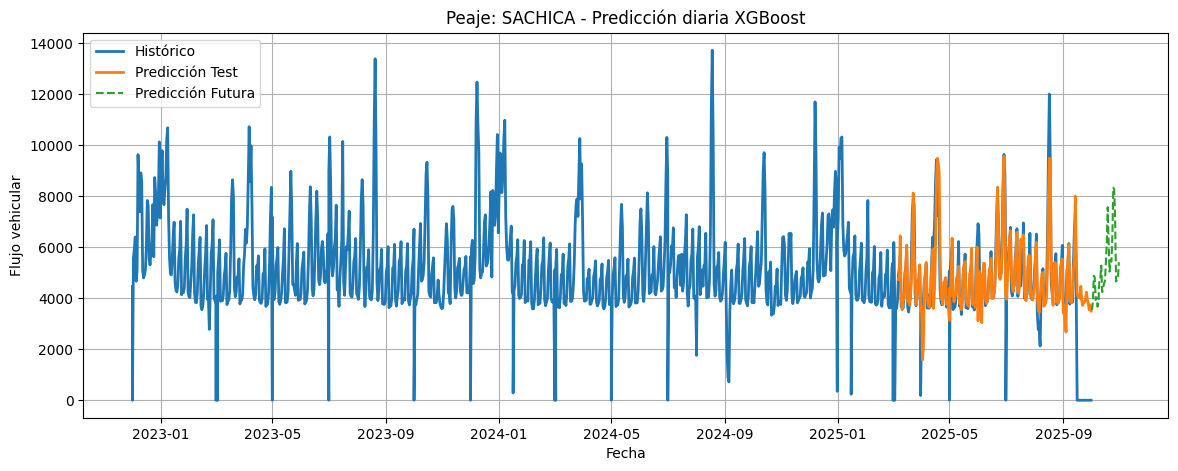

📁 CSV guardado en: ./resultados/SACHICA/predicciones_SACHICA.csv

=========== Procesando peaje CASABLANCA ===========
💡 MAE del peaje: 1236.81


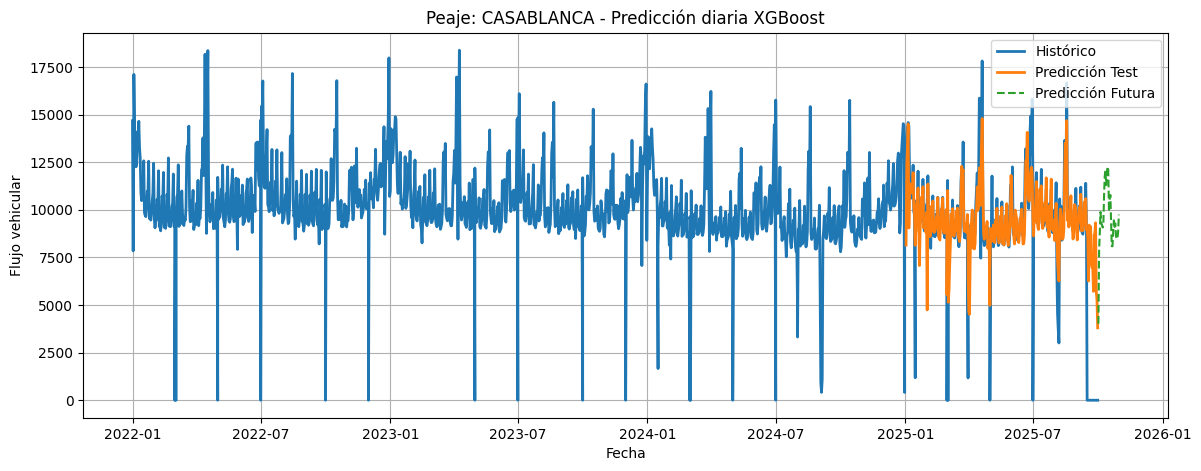

📁 CSV guardado en: ./resultados/CASABLANCA/predicciones_CASABLANCA.csv

=========== Procesando peaje TUNEL QUINDIO ===========
⚠️ Sin datos, saltando.

=========== Procesando peaje TUNEL TOLIMA ===========
⚠️ Sin datos, saltando.

=========== Procesando peaje CERRITOS II ===========
💡 MAE del peaje: 1255.68


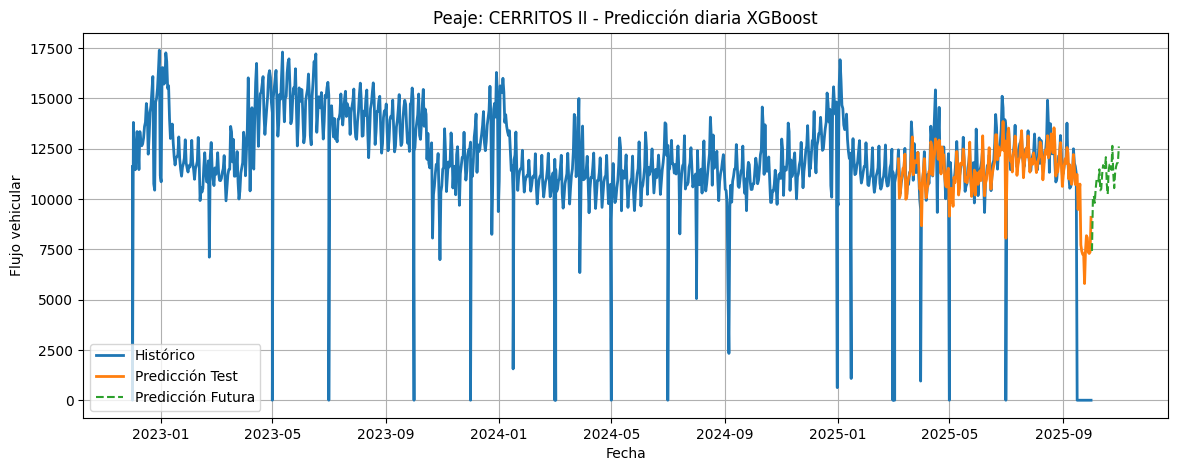

📁 CSV guardado en: ./resultados/CERRITOS_II/predicciones_CERRITOS_II.csv

=========== Procesando peaje BICENTENARIO ===========
💡 MAE del peaje: 374.72


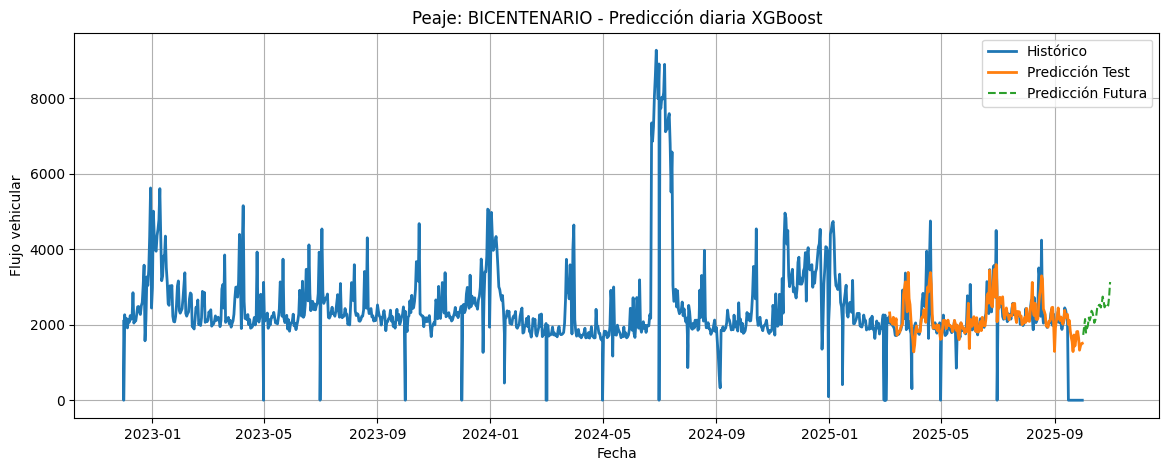

📁 CSV guardado en: ./resultados/BICENTENARIO/predicciones_BICENTENARIO.csv

=========== Procesando peaje LA PARADA ===========
💡 MAE del peaje: 9506.01


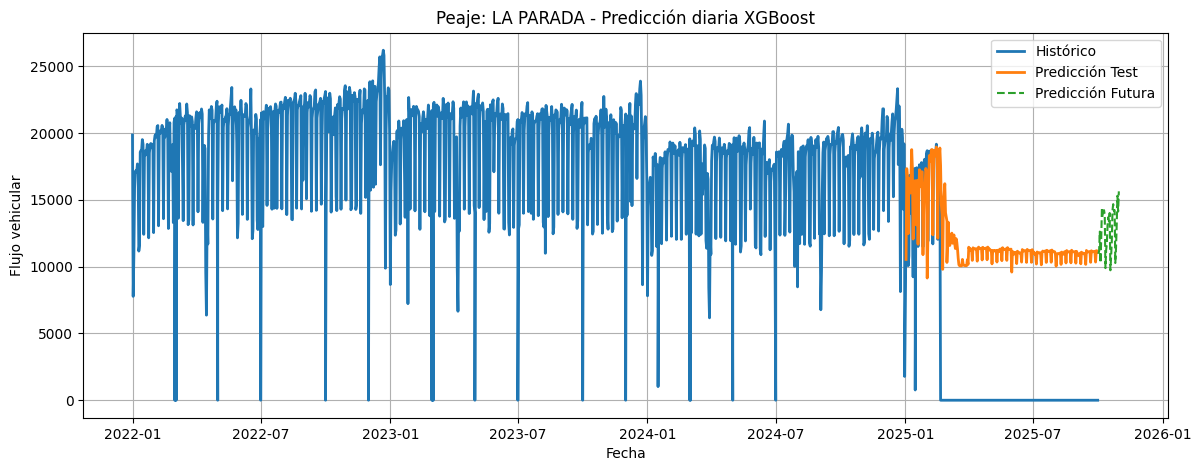

📁 CSV guardado en: ./resultados/LA_PARADA/predicciones_LA_PARADA.csv


In [7]:
df = pd.read_excel("./data/trafico_consolidado.xlsx")


# Limpieza
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df = df.dropna(subset=["fecha", "total", "peaje"])
df = df.sort_values("fecha")

# Lista de peajes
peajes = ['PTO. TRIUNFO', 'SACHICA', 'CASABLANCA', 'TUNEL QUINDIO','TUNEL TOLIMA',
           'CERRITOS II', 'BICENTENARIO', 'LA PARADA']

for peaje in peajes:
    print(f"\n=========== Procesando peaje {peaje} ===========")

    df_peaje = df[df["peaje"] == peaje].copy()

    if df_peaje.empty:
        print("⚠️ Sin datos, saltando.")
        continue

    # Ciclo independiente por peaje
    try:
        model, df_hist, df_future, idx_test, y_test, preds = entrenar_modelo_peaje(
            df_peaje, dias_prediccion=30
        )
    except Exception as e:
        print(f"❌ Error con peaje {peaje}: {e}")
        continue

    # ---------------------------
    # Gráfico por peaje
    # ---------------------------
    plt.figure(figsize=(14, 5))

    plt.plot(df_hist.index, df_hist["total"], label="Histórico", linewidth=2)
    plt.plot(idx_test, preds, label="Predicción Test", linewidth=2)

    future_dates = df_future.index[len(df_hist):]
    future_vals = df_future["total"].iloc[len(df_hist):]
    plt.plot(future_dates, future_vals, label="Predicción Futura", linestyle="--")

    plt.title(f"Peaje: {peaje} - Predicción diaria XGBoost")
    plt.xlabel("Fecha")
    plt.ylabel("Flujo vehicular")
    plt.grid(True)
    plt.legend()
    plt.show()

    output_dir = f"./resultados/{peaje.replace(' ', '_')}"
    os.makedirs(output_dir, exist_ok=True)
    csv_path = f"{output_dir}/predicciones_{peaje.replace(' ', '_')}.csv"
    df_future.to_csv(csv_path)
    print(f"📁 CSV guardado en: {csv_path}")

In [8]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\USUARIO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
import plotly.graph_objects as go

fig = go.Figure()

# Línea histórica
fig.add_trace(go.Scatter(
    x=df_hist.index,
    y=df_hist["total"],
    name="Histórico",
    mode="lines"
))

# Línea predicciones test
fig.add_trace(go.Scatter(
    x=idx_test,
    y=preds,
    name="Predicción Test",
    mode="lines"
))

# Línea predicción a futuro
future_dates = df_future.index[len(df_hist):]
future_vals = df_future["total"].iloc[len(df_hist):]

fig.add_trace(go.Scatter(
    x=future_dates,
    y=future_vals,
    name="Predicción Futura",
    mode="lines",
    line=dict(dash="dot")
))

# Título y ejes
fig.update_layout(
    title=f"Predicción de Tráfico - Peaje {peaje}",
    xaxis_title="Fecha",
    yaxis_title="Flujo Vehicular",
    template="plotly_white"
)

# ---------------------------
# 4. Exportar dashboard a HTML
# ---------------------------
html_path = f"{output_dir}/dashboard_{peaje.replace(' ', '_')}.html"
fig.write_html(html_path)
print(f"📊 Dashboard HTML guardado en: {html_path}")

📊 Dashboard HTML guardado en: ./resultados/LA_PARADA/dashboard_LA_PARADA.html
